# Assignment 1 2AMM10 2024-2025

## Group: YXY
### Member 1: Andy Wei 2135663
### Member 2: Nguyen Tran 1484567
### Member 3: Xiang Zou 2078473

In [1]:
import os
import pandas as pd
import torch 
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms
import kagglehub
import torchvision.transforms as transforms

# add additonal imports here
class FashionDataset(Dataset):
    def __init__(self, csv_file, img_dir,column_class="articleTypeId", transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with labels.
            img_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)  # load CSV file
        self.img_dir = img_dir  # image folder path
        self.transform = transform  # image transformations
        self.targets = list(self.df[column_class].values)


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.df.loc[idx,'imageId']}.jpg")  # Get image filename
        image = Image.open(img_name).convert("RGB")  # Load image

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, self.targets[idx]

c:\Users\Andy\DP_assignment1\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Download data with kagglehub

In [2]:
# import shutil
# import os

dataset_path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
img_dir = os.path.join(dataset_path,"images")

# shutil.rmtree(dataset_path)

The different datasets can be loaded using the class `FashionDataset` which is a custon PyTorch dataset (see [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more information). Below an example of how to use the `FashionDataset` constructor as well as some visualizations. Please note that you may have to adapt the arguments to match the strucucture of your working directory.

In [3]:
dataset = FashionDataset("dataset/train.csv",img_dir)

In [4]:
dataset.df.head()

,imageId,articleTypeName,categoryName,articleTypeId,categoryId
0,35180,Backpacks,Bags,15,2
1,33585,Tshirts,Topwear,0,0
2,9464,Shirts,Topwear,1,0
3,8194,Shirts,Topwear,1,0
4,42231,Tops,Topwear,6,0


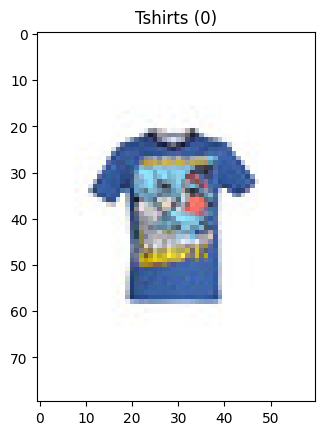

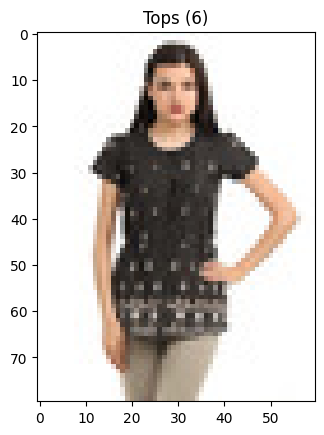

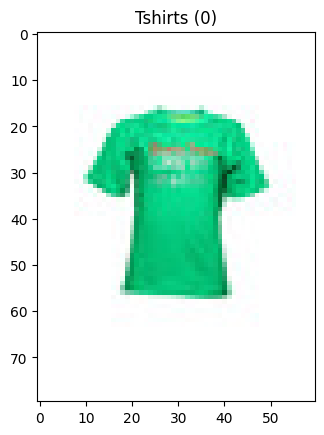

In [5]:
np.random.seed(42)
random_indices = np.random.choice(len(dataset),3)

for i in random_indices:
    img, label = dataset[i]
    plt.title(dataset.df.iloc[i]["articleTypeName"]+f" ({label.item()})")
    plt.imshow(img)
    plt.show()

## Loading different datasets

In [6]:
transform = transforms.Compose([
    transforms.Resize((60, 80)),
    # transforms.RandomHorizontalFlip(p=0.3),
    # transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# transform = transforms.Compose([
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(degrees=15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

train_dataset = FashionDataset("dataset/train.csv",img_dir,transform=transform)
main_test_dataset =  FashionDataset("dataset/main_test.csv",img_dir,transform=transform)
new_test_dataset =  FashionDataset("dataset/new_test.csv",img_dir,transform=transform)
main_support_dataset =  FashionDataset("dataset/main_support.csv",img_dir,transform=transform)
new_support_dataset =  FashionDataset("dataset/new_support.csv",img_dir,transform=transform)
merged_test_dataset =  FashionDataset("dataset/merged_test.csv",img_dir,transform=transform) # merged corresponds to main+new
merged_support_dataset =  FashionDataset("dataset/merged_support.csv",img_dir,transform=transform)

# datasets with categories
main_test_dataset_cat =  FashionDataset("dataset/main_test.csv",img_dir,column_class="categoryId",transform=transform)
main_support_dataset_cat =  FashionDataset("dataset/main_support.csv",img_dir,column_class="categoryId",transform=transform)


label_id_to_label_name = {i: train_dataset.df[train_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39)} 
label_id_to_label_name.update({i: new_test_dataset.df[new_test_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39,39+30)})

## Task 1

In [7]:
# your solution
# train dataset: train_dataset
# test datset: main_test_dataset

In [8]:
# define network archietecture

class FashionNet(torch.nn.Module):
    def __init__(self, num_classes):
        super(FashionNet, self).__init__()

        # convolutional layers
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size = 3, padding = 1)

        # batch normalization layers
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.bn3 = torch.nn.BatchNorm2d(128)

        # pooling layer
        self.pool = torch.nn.MaxPool2d(2, 2)

        # dropout layer
        self.dropout_light = torch.nn.Dropout(0.1)
        self.dropout = torch.nn.Dropout(0.25)

        # fully conneted layer
        # self.fc1 = torch.nn.Linear(128 * 28 * 28, 512)
        self.fc1 = torch.nn.Linear(128 * 7 * 10, 512)
        self.fc2 = torch.nn.Linear(512, num_classes)

        # activation function
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Second convolutional block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Third convolutional block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout_light(x) 
        x = self.pool(x)
        
        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        
        # Fully connected layers with dropout
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x # already without softmax => can be used as a feature

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001, restore_best_weights=True):

        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
                print("Early stopping triggered. Restored best weights.")

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()


Training

In [9]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.amp import autocast, GradScaler

# hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 1e-4
weight_decay = 1e-4

# create data loader
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(main_test_dataset, batch_size = batch_size, shuffle = False)

num_classes = len(train_dataset.df['articleTypeId'].unique())

# initialize the model
model = FashionNet(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Improved training function with AMP
def train_model(model, train_loader, test_loader, device, epochs=10):
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

    # Initialize gradient scaler for AMP
    scaler = GradScaler()
    
    # Initialize Early Stopping
    early_stopping = EarlyStopping(patience=3, min_delta=0.001)
    
    # Track best model
    best_test_acc = 0.0
    
    print(f"Starting training for {epochs} epochs...")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')
        
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            
            # Use AMP autocast
            with autocast(device_type='cuda', enabled=torch.cuda.is_available()):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            # Scale gradients and perform backward pass
            scaler.scale(loss).backward()
            
            # Update weights with scaled gradients
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
            
            train_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{(train_correct/train_total):.4f}'
            })
        
        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        
        # Test phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        test_pbar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs} [Test]')
        
        with torch.no_grad():
            for inputs, labels in test_pbar:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()
                
                test_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{(test_correct/test_total):.4f}'
                })
        
        test_loss = test_loss / len(test_loader)
        test_acc = test_correct / test_total
        
        # Update learning rate based on test accuracy
        scheduler.step(test_acc)
        
        # Early stopping check 
        early_stopping(test_loss, model)
        
        # Print results
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        print(f'Early Stopping Counter: {early_stopping.counter}/{early_stopping.patience}')

        # Clean GPU cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # Save best model
        if test_acc > best_test_acc: 
            best_test_acc = test_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"New best test accuracy: {test_acc:.4f}")
        
        # Check for early stopping 
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    print(f"Training completed! Best test accuracy: {best_test_acc:.4f}")
    return model

In [10]:
print(f"Using device: {device}")
model = train_model(model, train_loader, test_loader, device, 10)

Using device: cuda
Starting training for 10 epochs...


Epoch 1/10 [Test]: 100%|██████████| 63/63 [00:01<00:00, 54.76it/s, loss=0.9552, acc=0.8187]


Epoch 1/10:
Train Loss: 1.4520, Train Acc: 0.7365
Test Loss: 1.1783, Test Acc: 0.8187
Early Stopping Counter: 0/3
New best test accuracy: 0.8187


Epoch 2/10 [Test]: 100%|██████████| 63/63 [00:01<00:00, 59.67it/s, loss=0.8347, acc=0.8478]


Epoch 2/10:
Train Loss: 1.1569, Train Acc: 0.8372
Test Loss: 1.0905, Test Acc: 0.8478
Early Stopping Counter: 0/3
New best test accuracy: 0.8478


Epoch 3/10 [Test]: 100%|██████████| 63/63 [00:01<00:00, 57.95it/s, loss=0.8436, acc=0.8573]


Epoch 3/10:
Train Loss: 1.0814, Train Acc: 0.8634
Test Loss: 1.0659, Test Acc: 0.8573
Early Stopping Counter: 0/3
New best test accuracy: 0.8573


Epoch 4/10 [Test]: 100%|██████████| 63/63 [00:01<00:00, 60.35it/s, loss=0.8642, acc=0.8733]


Epoch 4/10:
Train Loss: 1.0323, Train Acc: 0.8829
Test Loss: 1.0355, Test Acc: 0.8733
Early Stopping Counter: 0/3
New best test accuracy: 0.8733


Epoch 5/10 [Test]: 100%|██████████| 63/63 [00:01<00:00, 60.12it/s, loss=0.8550, acc=0.8783]


Epoch 5/10:
Train Loss: 0.9945, Train Acc: 0.8979
Test Loss: 1.0143, Test Acc: 0.8783
Early Stopping Counter: 0/3
New best test accuracy: 0.8783


Epoch 6/10 [Test]: 100%|██████████| 63/63 [00:01<00:00, 58.86it/s, loss=0.8429, acc=0.8903]


Epoch 6/10:
Train Loss: 0.9679, Train Acc: 0.9078
Test Loss: 1.0010, Test Acc: 0.8903
Early Stopping Counter: 0/3
New best test accuracy: 0.8903


Epoch 7/10 [Test]: 100%|██████████| 63/63 [00:01<00:00, 59.61it/s, loss=0.8265, acc=0.8933]


Epoch 7/10:
Train Loss: 0.9433, Train Acc: 0.9171
Test Loss: 0.9882, Test Acc: 0.8933
Early Stopping Counter: 0/3
New best test accuracy: 0.8933


Epoch 8/10 [Test]: 100%|██████████| 63/63 [00:01<00:00, 60.34it/s, loss=0.8529, acc=0.8893]


Epoch 8/10:
Train Loss: 0.9229, Train Acc: 0.9271
Test Loss: 0.9977, Test Acc: 0.8893
Early Stopping Counter: 1/3


Epoch 9/10 [Test]: 100%|██████████| 63/63 [00:01<00:00, 59.30it/s, loss=0.8423, acc=0.8893]


Epoch 9/10:
Train Loss: 0.9045, Train Acc: 0.9340
Test Loss: 0.9834, Test Acc: 0.8893
Early Stopping Counter: 0/3


Epoch 10/10 [Test]: 100%|██████████| 63/63 [00:01<00:00, 58.75it/s, loss=0.7603, acc=0.8958]

Epoch 10/10:
Train Loss: 0.8880, Train Acc: 0.9424
Test Loss: 0.9723, Test Acc: 0.8958
Early Stopping Counter: 0/3
New best test accuracy: 0.8958
Training completed! Best test accuracy: 0.8958


In [11]:
from sklearn.metrics import balanced_accuracy_score
def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No need to track gradients
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Regular accuracy
    accuracy = 100 * correct / total
    # Balanced accuracy
    balanced_acc = 100 * balanced_accuracy_score(all_labels, all_preds)
    
    return accuracy, balanced_acc

# After training your model
acc, bal_acc = evaluate_model(model, test_loader, device)
print(f'Accuracy: {acc:.2f}%')
print(f'Balanced Accuracy: {bal_acc:.2f}%')

Accuracy: 89.58%
Balanced Accuracy: 83.75%


## Task 2

In [12]:
# your solution
# train dataset: train_dataset
# test and support dataset: see scenarios table

In [13]:
import torch.nn.functional as F
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)

In [14]:
class FashionNetT2(torch.nn.Module):
    def __init__(self, embedding_dim=256):
        super(FashionNetT2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.embedding_dim = embedding_dim
        self.fc1 = nn.Linear(128 * 7 * 10, 512)
        self.fc2 = nn.Linear(512, embedding_dim)  # Now outputs a feature vector

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        embedding = self.fc2(x)  # Output feature vector
        return embedding
    


In [15]:
def train_triplet_model(model, triplet_loader, device, epochs=10):
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
        criterion = nn.TripletMarginLoss(margin=1.0, p=2)

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0

            for anchor, positive, negative in tqdm(triplet_loader, desc=f"Epoch {epoch+1}/{epochs}"):
                anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

                optimizer.zero_grad()

                emb_a = model(anchor)
                emb_p = model(positive)
                emb_n = model(negative)

                loss = criterion(emb_a, emb_p, emb_n)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            print(f"Epoch {epoch+1}, Loss: {running_loss/len(triplet_loader):.4f}")
        torch.save(model.state_dict(), 'task2_model.pth')



In [16]:
from torch.utils.data import Dataset
import random
from collections import defaultdict
class TripletFashionDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.labels = base_dataset.targets
        self.label_to_indices = self._build_index()

    def _build_index(self):
        label_to_indices = defaultdict(list)
        for idx, label in enumerate(self.labels):
            label_to_indices[label].append(idx)
        return label_to_indices

    def __getitem__(self, index):
        anchor_img, anchor_label = self.base_dataset[index]

        # Positive sample
        positive_index = index
        while positive_index == index:
            positive_index = random.choice(self.label_to_indices[anchor_label])
        positive_img, _ = self.base_dataset[positive_index]

        # Negative sample
        negative_label = anchor_label
        while negative_label == anchor_label:
            negative_label = random.choice(list(self.label_to_indices.keys()))
        negative_index = random.choice(self.label_to_indices[negative_label])
        negative_img, _ = self.base_dataset[negative_index]

        return anchor_img, positive_img, negative_img

    def __len__(self):
        return len(self.base_dataset)

In [17]:
# Use your existing dataset
triplet_dataset = TripletFashionDataset(train_dataset)
triplet_loader = DataLoader(triplet_dataset, batch_size=32, shuffle=True)

# Train the model with triplet loss

model_2 = FashionNetT2(embedding_dim=128)
train_triplet_model(model_2, triplet_loader, device, epochs=10)


Epoch 1/10: 100%|██████████| 1123/1123 [01:08<00:00, 16.35it/s]


Epoch 1, Loss: 0.1667


Epoch 2/10: 100%|██████████| 1123/1123 [01:09<00:00, 16.06it/s]


Epoch 2, Loss: 0.0744


Epoch 3/10: 100%|██████████| 1123/1123 [01:09<00:00, 16.09it/s]


Epoch 3, Loss: 0.0502


Epoch 4/10: 100%|██████████| 1123/1123 [01:43<00:00, 10.87it/s]


Epoch 4, Loss: 0.0438


Epoch 5/10: 100%|██████████| 1123/1123 [01:14<00:00, 15.12it/s]


Epoch 5, Loss: 0.0365


Epoch 6/10: 100%|██████████| 1123/1123 [01:26<00:00, 12.99it/s]


Epoch 6, Loss: 0.0362


Epoch 7/10: 100%|██████████| 1123/1123 [02:19<00:00,  8.05it/s]


Epoch 7, Loss: 0.0408


Epoch 8/10: 100%|██████████| 1123/1123 [01:24<00:00, 13.34it/s]


Epoch 8, Loss: 0.0280


Epoch 9/10: 100%|██████████| 1123/1123 [01:08<00:00, 16.33it/s]


Epoch 9, Loss: 0.0288


Epoch 10/10: 100%|██████████| 1123/1123 [01:08<00:00, 16.40it/s]

Epoch 10, Loss: 0.0240


In [18]:
# Support Set Embedding
def compute_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Computing embeddings"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            embeddings.append(outputs.cpu())
            labels.extend(targets.cpu().numpy())

    embeddings = torch.cat(embeddings).numpy()  # [N, D]
    return embeddings, labels
# KNN
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier

def classify_knn(support_embeddings, support_labels, test_embeddings, test_labels, k=1):
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(support_embeddings, support_labels)
    preds = knn.predict(test_embeddings)

    acc = accuracy_score(test_labels, preds) * 100
    bal_acc = balanced_accuracy_score(test_labels, preds) * 100
    return acc, bal_acc


In [62]:
# Scenario 1
support_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(main_test_dataset, batch_size=64, shuffle=False)
support_embeddings, support_labels = compute_embeddings(model_2, support_loader, device)
test_embeddings, test_labels = compute_embeddings(model_2, test_loader, device)


acc, bal_acc = classify_knn(support_embeddings, support_labels, test_embeddings, test_labels)

print(f"Test Accuracy: {acc:.2f}%, Balanced Accuracy: {bal_acc:.2f}%")


Computing embeddings: 100%|██████████| 32/32 [00:01<00:00, 26.26it/s]


Test Accuracy: 77.57%, Balanced Accuracy: 71.71%


In [20]:
# Scenario 2
support_loader = DataLoader(main_support_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(main_test_dataset, batch_size=64, shuffle=False)
support_embeddings, support_labels = compute_embeddings(model_2, support_loader, device)
test_embeddings, test_labels = compute_embeddings(model_2, test_loader, device)


acc, bal_acc = classify_knn(support_embeddings, support_labels, test_embeddings, test_labels)

print(f"Test Accuracy: {acc:.2f}%, Balanced Accuracy: {bal_acc:.2f}%")


Computing embeddings: 100%|██████████| 32/32 [00:01<00:00, 26.53it/s]

Test Accuracy: 71.56%, Balanced Accuracy: 64.57%


In [21]:
# Scenario 3
support_loader = DataLoader(new_support_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(new_test_dataset, batch_size=64, shuffle=False)
support_embeddings, support_labels = compute_embeddings(model_2, support_loader, device)
test_embeddings, test_labels = compute_embeddings(model_2, test_loader, device)

acc, bal_acc = classify_knn(support_embeddings, support_labels, test_embeddings, test_labels)
print(f"[Scenario 3] Accuracy: {acc:.2f}%, Balanced Accuracy: {bal_acc:.2f}%")


Computing embeddings: 100%|██████████| 26/26 [00:01<00:00, 15.53it/s]

[Scenario 3] Accuracy: 71.39%, Balanced Accuracy: 71.14%


In [22]:
# Scenario 4
support_loader = DataLoader(merged_support_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(merged_test_dataset, batch_size=64, shuffle=False)
support_embeddings, support_labels = compute_embeddings(model_2, support_loader, device)
test_embeddings, test_labels = compute_embeddings(model_2, test_loader, device)
acc, bal_acc = classify_knn(support_embeddings, support_labels, test_embeddings, test_labels)
print(f"[Scenario 4] Accuracy: {acc:.2f}%, Balanced Accuracy: {bal_acc:.2f}%")


Computing embeddings: 100%|██████████| 58/58 [00:02<00:00, 26.21it/s]


[Scenario 4] Accuracy: 64.45%, Balanced Accuracy: 59.38%


## Task 3

In [23]:
# your solution
# test dataset: merged_test_dataset
# support/catalog dataset: support_test_dataset

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

%matplotlib inline
plt.style.use('ggplot')

In [90]:
# methods to compute top-k and confidence values

In [91]:
def compute_confidence(similarities):
    return similarities[0] - similarities[2]

In [92]:
# plot func

In [93]:
def plot(error_rates,coverage_rates):
    plt.figure(figsize=(8, 6))
    plt.plot(error_rates, coverage_rates, marker='o', color='orange')
    plt.xlabel('Error Rate (%)')
    plt.ylabel('Coverage (%)')
    plt.title('Error Rate vs. Coverage')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [94]:
# evaluate recommendation func

In [96]:
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

def evaluate_recommendation(support_features,support_labels,test_features,test_labels):
    thresholds = np.linspace(0, 1, 42)
    error_rates = []
    coverage_rates = []

    # Nearest Neighbors model
    nn_model = NearestNeighbors(n_neighbors=3, metric='cosine')
    nn_model.fit(support_features)
    
    for threshold in tqdm(thresholds):
        total = len(test_features)
        shown = 0
        incorrect = 0
    
        for i, test_feature in enumerate(test_features):
            distances, indices = nn_model.kneighbors([test_feature], n_neighbors=3)
            similarities = 1 - distances[0]
            confidence = similarities[0] - similarities[2]    
            if confidence >= threshold:
                shown += 1
                recommended_labels = support_labels[indices[0]]
                if test_labels[i] not in recommended_labels:
                    incorrect += 1
    
        coverage = shown / total if total else 0
        error_rate = incorrect / shown if shown else 0
        coverage_rates.append(coverage * 100)
        error_rates.append(error_rate * 100)

    return thresholds,error_rates,coverage_rates

In [97]:
# Get features

In [99]:
import torch.nn.functional as F

def classify_by_nearest_neighbor(test_features, support_features, support_labels, metric='cosine'):
    predictions = []

    for test_feat in test_features:
        if metric == 'cosine':
            sims = F.cosine_similarity(test_feat.unsqueeze(0), support_features)
            idx = torch.argmax(sims).item()
        if metric == 'euclidean':
            dists = torch.norm(support_features - test_feat.unsqueeze(0), dim=1)
            idx = torch.argmin(dists).item()

        predictions.append(support_labels[idx])
    
    return predictions

In [100]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

def evaluate_predictions(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc * 100:.2f}%")
    print(f"Balanced Accuracy: {bal_acc * 100:.2f}%")
    return acc, bal_acc

In [101]:
def extract_features(model, dataloader, device):
    model.eval()
    features, labels = [], []

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Extracting features"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu())
            labels.extend(targets.cpu().tolist())

    return torch.cat(features), labels

In [106]:
from torch.utils.data import DataLoader

merged_support_loader = DataLoader(merged_support_dataset, batch_size=32, shuffle=False)
merged_test_loader = DataLoader(merged_test_dataset, batch_size=32, shuffle=False)

support_features, support_labels = extract_features(model_2, merged_support_loader, device)
test_features, test_labels = extract_features(model_2, merged_test_loader, device)

Extracting features: 100%|██████████| 115/115 [00:01<00:00, 59.22it/s]


In [107]:
support_features = support_features.numpy()
test_features = test_features.numpy()
support_labels = np.array(support_labels)
test_labels = np.array(test_labels)

In [108]:
thresholds,error_rates,coverage_rates = evaluate_recommendation(support_features,support_labels,test_features,test_labels)

100%|██████████| 42/42 [03:20<00:00,  4.77s/it]


In [109]:
target_error = 10.0

for t, e, c in zip(thresholds, error_rates, coverage_rates):
    if e <= target_error:
        print(f"Threshold: {t:.3f}, Error Rate: {e:.2f}%, Coverage: {c:.2f}%")

Threshold: 0.049, Error Rate: 6.95%, Coverage: 7.08%
Threshold: 0.073, Error Rate: 2.83%, Coverage: 2.90%
Threshold: 0.098, Error Rate: 6.38%, Coverage: 1.29%
Threshold: 0.122, Error Rate: 4.55%, Coverage: 0.60%
Threshold: 0.146, Error Rate: 0.00%, Coverage: 0.25%
Threshold: 0.171, Error Rate: 0.00%, Coverage: 0.03%
Threshold: 0.195, Error Rate: 0.00%, Coverage: 0.03%
Threshold: 0.220, Error Rate: 0.00%, Coverage: 0.00%
Threshold: 0.244, Error Rate: 0.00%, Coverage: 0.00%
Threshold: 0.268, Error Rate: 0.00%, Coverage: 0.00%
Threshold: 0.293, Error Rate: 0.00%, Coverage: 0.00%
Threshold: 0.317, Error Rate: 0.00%, Coverage: 0.00%
Threshold: 0.341, Error Rate: 0.00%, Coverage: 0.00%
Threshold: 0.366, Error Rate: 0.00%, Coverage: 0.00%
Threshold: 0.390, Error Rate: 0.00%, Coverage: 0.00%
Threshold: 0.415, Error Rate: 0.00%, Coverage: 0.00%
Threshold: 0.439, Error Rate: 0.00%, Coverage: 0.00%
Threshold: 0.463, Error Rate: 0.00%, Coverage: 0.00%
Threshold: 0.488, Error Rate: 0.00%, Coverage:

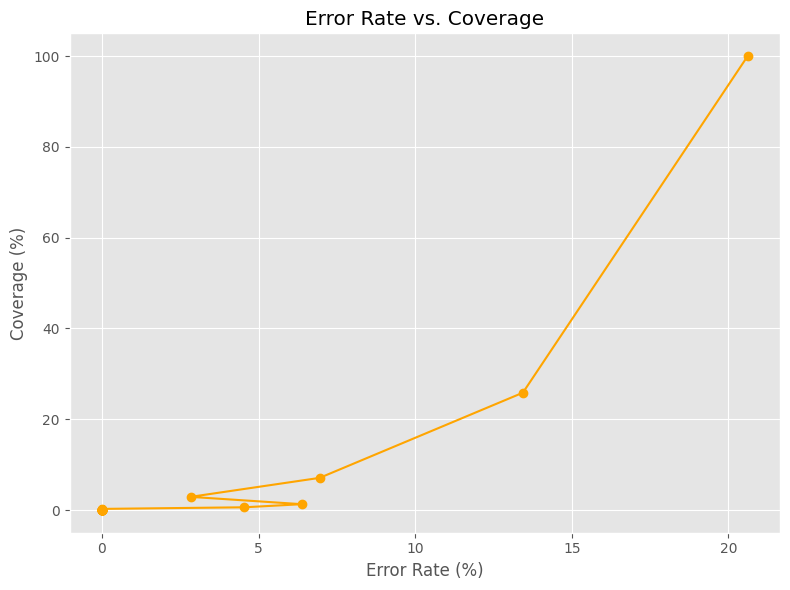

In [110]:
plot(error_rates,coverage_rates)

## Task 4

In [39]:
# your solution
# datasets: first 10 classes of train_dataset and main_test_dataset

In [41]:
# Import required libraries for dimensionality reduction and visualization
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import pandas as pd
from sklearn.metrics import pairwise_distances

In [45]:
# Load your trained Task 2 model
model_2 = FashionNetT2(embedding_dim=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2.to(device)
# try:
#     model_task2.load_state_dict(torch.load('model_task2.pth'))
#     print("Successfully loaded Task 2 model")
# except:
#     print("Warning: Could not load model_task2.pth. Make sure Task 2 training is complete.")
#     print("Using current model state...")
# model_task2 = model_task2.to(device)
# model_task2.eval()

FashionNetT2(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=8960, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (relu): ReLU()
)

In [130]:
# Step1
def filter_dataset_first_10_classes_robust(dataset, max_class_id=9):
    """Robust filtering that handles index mismatches"""
    valid_indices = []
    
    print(f"Filtering dataset for classes 0-{max_class_id}...")
    
    # Check what classes are available first
    available_classes = set()
    for i in range(min(100, len(dataset))):  # Sample first 100 to check
        try:
            _, label = dataset[i]
            available_classes.add(label)
        except:
            continue
    
    print(f"Available classes in dataset: {sorted(available_classes)}")
    
    # Now filter for the desired classes
    for i in range(len(dataset)):
        try:
            _, label = dataset[i]
            if label <= max_class_id:
                valid_indices.append(i)
        except (KeyError, IndexError) as e:
            continue
    
    print(f"Found {len(valid_indices)} valid samples for first {max_class_id+1} classes")
    return Subset(dataset, valid_indices)

# Create filtered datasets for first 10 classes
print("Filtering train dataset...")
train_first_10 = filter_dataset_first_10_classes_robust(train_dataset, max_class_id=9)
main_support_first_10 = filter_dataset_first_10_classes_robust(main_support_dataset, max_class_id=9)
print("Filtering main test dataset...")
main_test_first_10 = filter_dataset_first_10_classes_robust(main_test_dataset, max_class_id=9)

# Create DataLoaders for the filtered datasets
train_first_10_loader = DataLoader(train_first_10, batch_size=32, shuffle=False)
main_test_first_10_loader = DataLoader(main_test_first_10, batch_size=32, shuffle=False)
main_support_first_10_loader = DataLoader(main_support_first_10, batch_size=32, shuffle=False)
print(f"Train dataset (first 10 classes): {len(train_first_10)} samples")
print(f"Main support dataset (first 10 classes): {len(main_support_first_10)} samples")
print(f"Test dataset (first 10 classes): {len(main_test_first_10)} samples")

Filtering train dataset...
Filtering dataset for classes 0-9...
Available classes in dataset: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(25), np.int64(29), np.int64(30), np.int64(31), np.int64(33), np.int64(34), np.int64(35)]
Found 22911 valid samples for first 10 classes
Filtering dataset for classes 0-9...
Available classes in dataset: [np.int64(0), np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(21), np.int64(22), np.int64(23), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(34), np.int64(35), np.int64(37

In [125]:
# Use your existing compute_embeddings function but rename for clarity
def extract_features_task4(model, dataloader, device):
    """Extract features using the trained Task 2 model"""
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Extracting features"):
            inputs = inputs.to(device)
            outputs = model(inputs)  # Get embeddings from Task 2 model
            features.append(outputs.cpu())
            labels.extend(targets.cpu().numpy())
    
    features = torch.cat(features).numpy()  # [N, embedding_dim]
    return features, np.array(labels)
def apply_tsne_visualization(features, labels, label_names, title_suffix=""):
    """
    Apply t-SNE dimensionality reduction and create scatter plot.
    t-SNE is a non-linear dimensionality reduction technique that preserves local structure 
    in the data, making it effective for visualizing high-dimensional feature representations.
    """
    print(f"Applying t-SNE to {len(features)} samples...")
    
    # Adjust perplexity based on dataset size
    perplexity = min(30, len(features) // 4)
    perplexity = max(5, perplexity)  # Ensure minimum perplexity
    
    # Apply t-SNE reduction
    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=perplexity,
        n_iter=1000,
        n_jobs=1
    )
    reduced_features = tsne.fit_transform(features)
    
    # Create scatter plot
    plt.figure(figsize=(14, 10))
    
    # Get unique classes and create color map
    unique_classes = sorted(set(labels))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_classes)))
    
    # Plot each class
    for i, class_id in enumerate(unique_classes):
        mask = labels == class_id
        if np.any(mask):
            class_name = label_names.get(class_id, f"Class {class_id}")
            plt.scatter(
                reduced_features[mask, 0],
                reduced_features[mask, 1],
                c=[colors[i]],
                label=f"{class_name} ({class_id})",
                alpha=0.7,
                s=40,
                edgecolors='black',
                linewidth=0.5
            )
    
    plt.title(f't-SNE Visualization of Task 2 Features - {title_suffix}', fontsize=16, fontweight='bold')
    plt.xlabel('t-SNE Component 1', fontsize=14)
    plt.ylabel('t-SNE Component 2', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return reduced_features



C:\Users\Andy\AppData\Local\Temp\ipykernel_21800\578045236.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_2.load_state_dict(torch.load('task2_model.pth'))


TASK 4, STEP 1: VISUALIZING THE FEATURE LANDSCAPE

1. Extracting features from training dataset (first 10 classes)...


Extracting features: 100%|██████████| 716/716 [00:17<00:00, 42.07it/s]



2. Extracting features from test dataset (first 10 classes)...


Extracting features: 100%|██████████| 40/40 [00:02<00:00, 15.87it/s]
c:\Users\Andy\DP_assignment1\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Dataset Information:
Train features shape: (22911, 128)
Test features shape: (1253, 128)
Feature dimension: 128

3. Generating t-SNE visualizations...

--- Training Dataset Visualization ---
Applying t-SNE to 22911 samples...


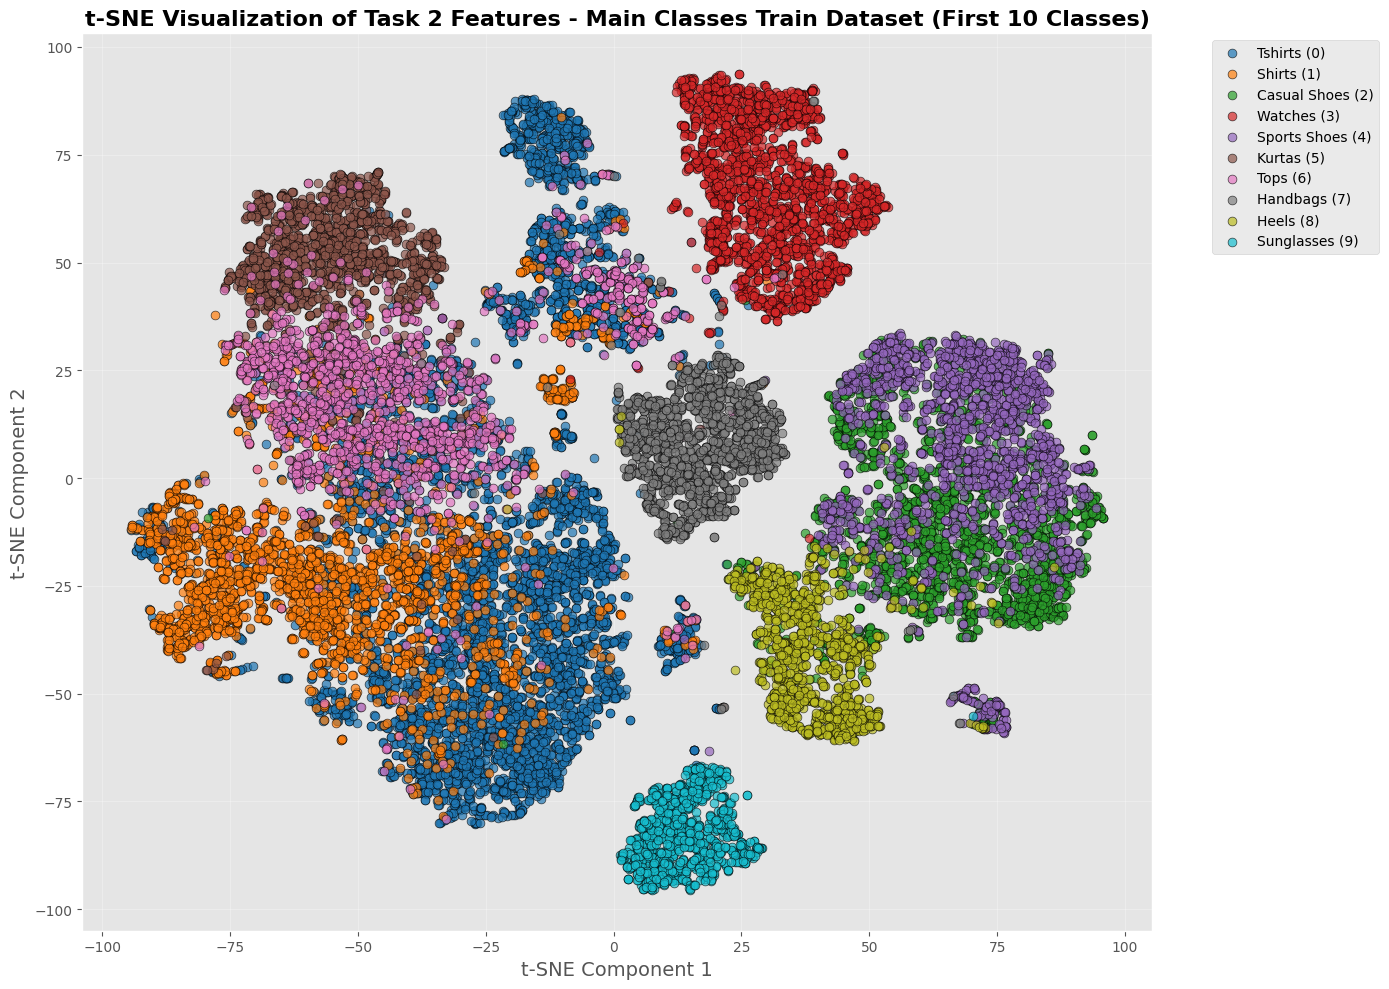


--- Test Dataset Visualization ---
Applying t-SNE to 1253 samples...


c:\Users\Andy\DP_assignment1\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


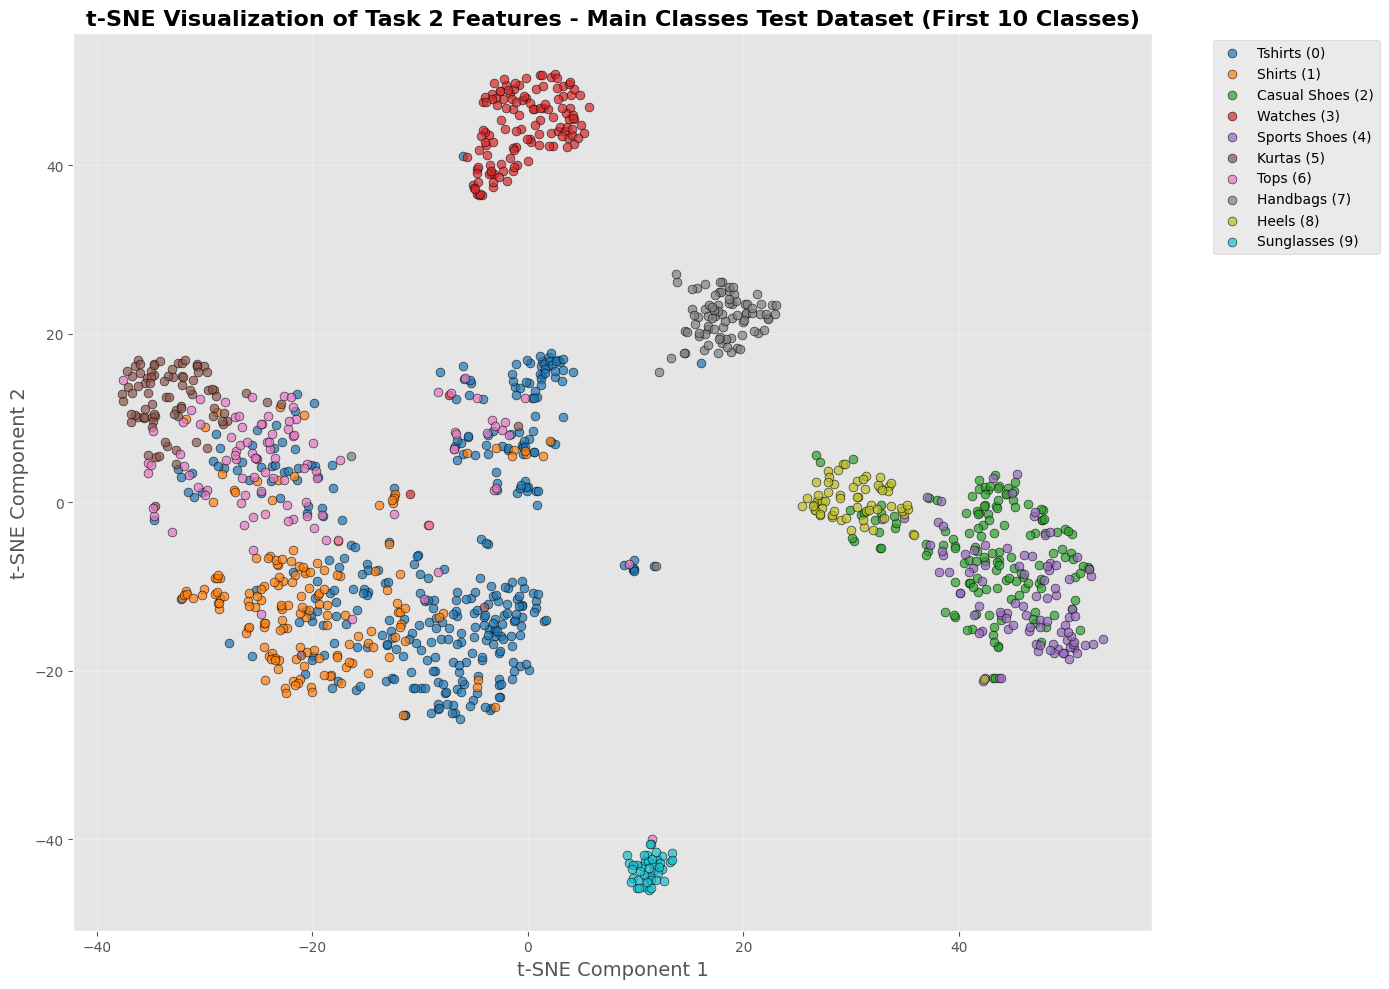

In [126]:
model_2 = FashionNetT2(embedding_dim=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2.load_state_dict(torch.load('task2_model.pth'))
model_2.to(device)

# Main execution for Task 4, Step 1
print("="*60)
print("TASK 4, STEP 1: VISUALIZING THE FEATURE LANDSCAPE")
print("="*60)

# Extract features from both datasets
print("\n1. Extracting features from training dataset (first 10 classes)...")
train_features, train_labels = extract_features_task4(model_2, train_first_10_loader, device)

print("\n2. Extracting features from test dataset (first 10 classes)...")
test_features, test_labels = extract_features_task4(model_2, main_test_first_10_loader, device)

print(f"\nDataset Information:")
print(f"Train features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")
print(f"Feature dimension: {train_features.shape[1]}")

# Generate scatter plots for both datasets
print("\n3. Generating t-SNE visualizations...")

print("\n--- Training Dataset Visualization ---")
train_tsne = apply_tsne_visualization(
    train_features, train_labels, label_id_to_label_name,
    'Main Classes Train Dataset (First 10 Classes)'
)

print("\n--- Test Dataset Visualization ---")
test_tsne = apply_tsne_visualization(
    test_features, test_labels, label_id_to_label_name,
    'Main Classes Test Dataset (First 10 Classes)'
)




=== SIDE-BY-SIDE COMPARISONS ===


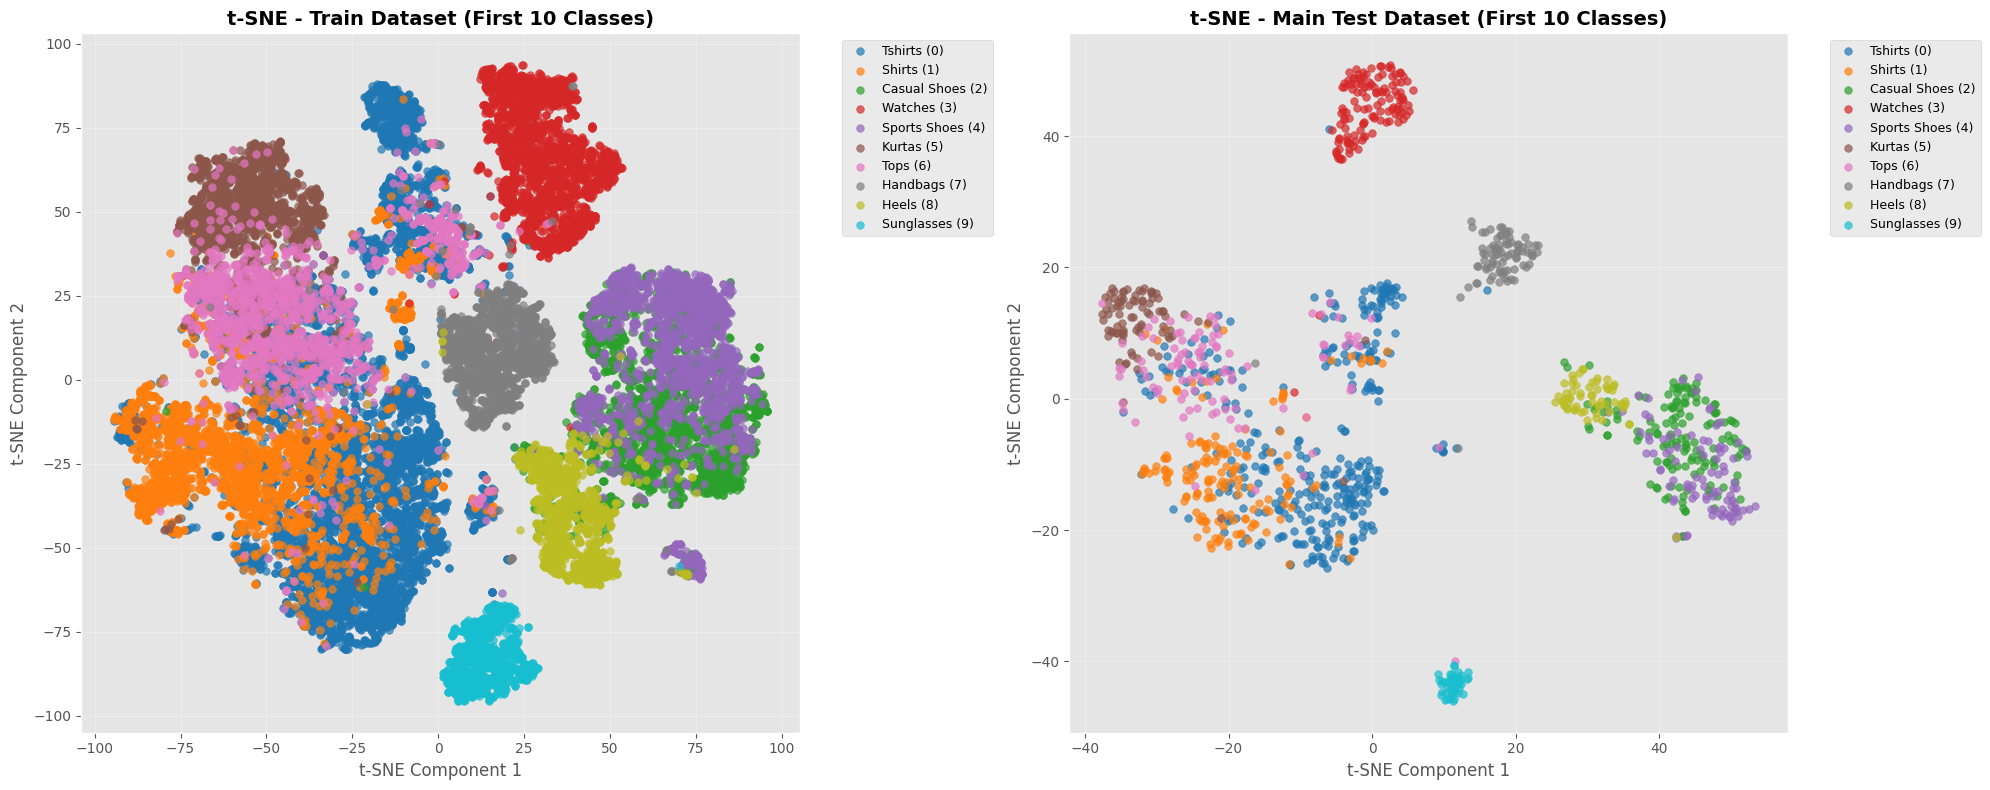

In [124]:
def create_comparison_plot_task4(train_reduced, train_labels, test_reduced, test_labels, method_name):
    """Create a comparison plot showing both train and test datasets side by side"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Get unique classes from both datasets - fix the concatenation
    all_classes = sorted(set(np.concatenate([train_labels, test_labels])))
    colors = plt.cm.tab10(range(len(all_classes)))
    
    # Plot train dataset
    for i, class_id in enumerate(all_classes):
        train_mask = train_labels == class_id
        if np.any(train_mask):
            class_name = label_id_to_label_name.get(class_id, f"Class {class_id}")
            ax1.scatter(train_reduced[train_mask, 0], train_reduced[train_mask, 1], 
                       c=[colors[i]], label=f"{class_name} ({class_id})", alpha=0.7, s=30)
    
    ax1.set_title(f'{method_name} - Train Dataset (First 10 Classes)', fontsize=14, fontweight='bold')
    ax1.set_xlabel(f'{method_name} Component 1', fontsize=12)
    ax1.set_ylabel(f'{method_name} Component 2', fontsize=12)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Plot test dataset
    for i, class_id in enumerate(all_classes):
        test_mask = test_labels == class_id
        if np.any(test_mask):
            class_name = label_id_to_label_name.get(class_id, f"Class {class_id}")
            ax2.scatter(test_reduced[test_mask, 0], test_reduced[test_mask, 1], 
                       c=[colors[i]], label=f"{class_name} ({class_id})", alpha=0.7, s=30)
    
    ax2.set_title(f'{method_name} - Main Test Dataset (First 10 Classes)', fontsize=14, fontweight='bold')
    ax2.set_xlabel(f'{method_name} Component 1', fontsize=12)
    ax2.set_ylabel(f'{method_name} Component 2', fontsize=12)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('t-SNE_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create comparison plots
print("\n=== SIDE-BY-SIDE COMPARISONS ===")
create_comparison_plot_task4(train_tsne, train_labels, test_tsne, test_labels, "t-SNE")


In [50]:
def analyze_cluster_separation_task4(features, labels, method_name):
    """Analyze which classes form distinct clusters and which overlap"""
    print(f"\n=== QUANTITATIVE ANALYSIS: {method_name} ===")
    
    # Calculate within-class and between-class distances
    distances = pairwise_distances(features)
    
    within_class_distances = []
    between_class_distances = []
    
    for i in range(len(features)):
        for j in range(i+1, len(features)):
            if labels[i] == labels[j]:
                within_class_distances.append(distances[i, j])
            else:
                between_class_distances.append(distances[i, j])
    
    if within_class_distances and between_class_distances:
        avg_within = np.mean(within_class_distances)
        avg_between = np.mean(between_class_distances)
        
        print(f"Average within-class distance: {avg_within:.4f}")
        print(f"Average between-class distance: {avg_between:.4f}")
        print(f"Separation ratio (between/within): {avg_between/avg_within:.4f}")
        
        # Higher separation ratio = better clustering
        if avg_between/avg_within > 1.5:
            print("✓ Good class separation!")
        elif avg_between/avg_within > 1.2:
            print("Moderate class separation")
        else:
            print("Poor class separation")
    
    # Analyze per-class clustering
    print("\nPer-class compactness analysis:")
    unique_classes = sorted(set(labels))
    class_compactness = {}
    
    for class_id in unique_classes:
        class_mask = np.array(labels) == class_id
        class_count = np.sum(class_mask)
        
        if class_count > 1:
            class_features = features[class_mask]
            class_distances = pairwise_distances(class_features)
            avg_class_distance = np.mean(class_distances[class_distances > 0])
            class_compactness[class_id] = avg_class_distance
            
            class_name = label_id_to_label_name.get(class_id, f"Class {class_id}")
            print(f"  {class_name} ({class_id}): {class_count} samples, "
                  f"avg intra-class distance = {avg_class_distance:.4f}")
    
    return class_compactness

# Perform quantitative analysis
train_tsne_analysis = analyze_cluster_separation_task4(train_tsne, train_labels, "t-SNE (Train)")
test_tsne_analysis = analyze_cluster_separation_task4(test_tsne, test_labels, "t-SNE (Test)")



=== QUANTITATIVE ANALYSIS: t-SNE (Train) ===
Average within-class distance: 51.2481
Average between-class distance: 81.5037
Separation ratio (between/within): 1.5904
✓ Good class separation!

Per-class compactness analysis:
  Tshirts (0): 6339 samples, avg intra-class distance = 64.1139
  Shirts (1): 2906 samples, avg intra-class distance = 50.5961
  Casual Shoes (2): 2552 samples, avg intra-class distance = 33.2133
  Watches (3): 2282 samples, avg intra-class distance = 28.7916
  Sports Shoes (4): 1834 samples, avg intra-class distance = 38.6179
  Kurtas (5): 1661 samples, avg intra-class distance = 27.8748
  Tops (6): 1566 samples, avg intra-class distance = 44.9964
  Handbags (7): 1580 samples, avg intra-class distance = 22.6681
  Heels (8): 1212 samples, avg intra-class distance = 20.2188
  Sunglasses (9): 979 samples, avg intra-class distance = 11.5611

=== QUANTITATIVE ANALYSIS: t-SNE (Test) ===
Average within-class distance: 23.0991
Average between-class distance: 40.7057
Separ

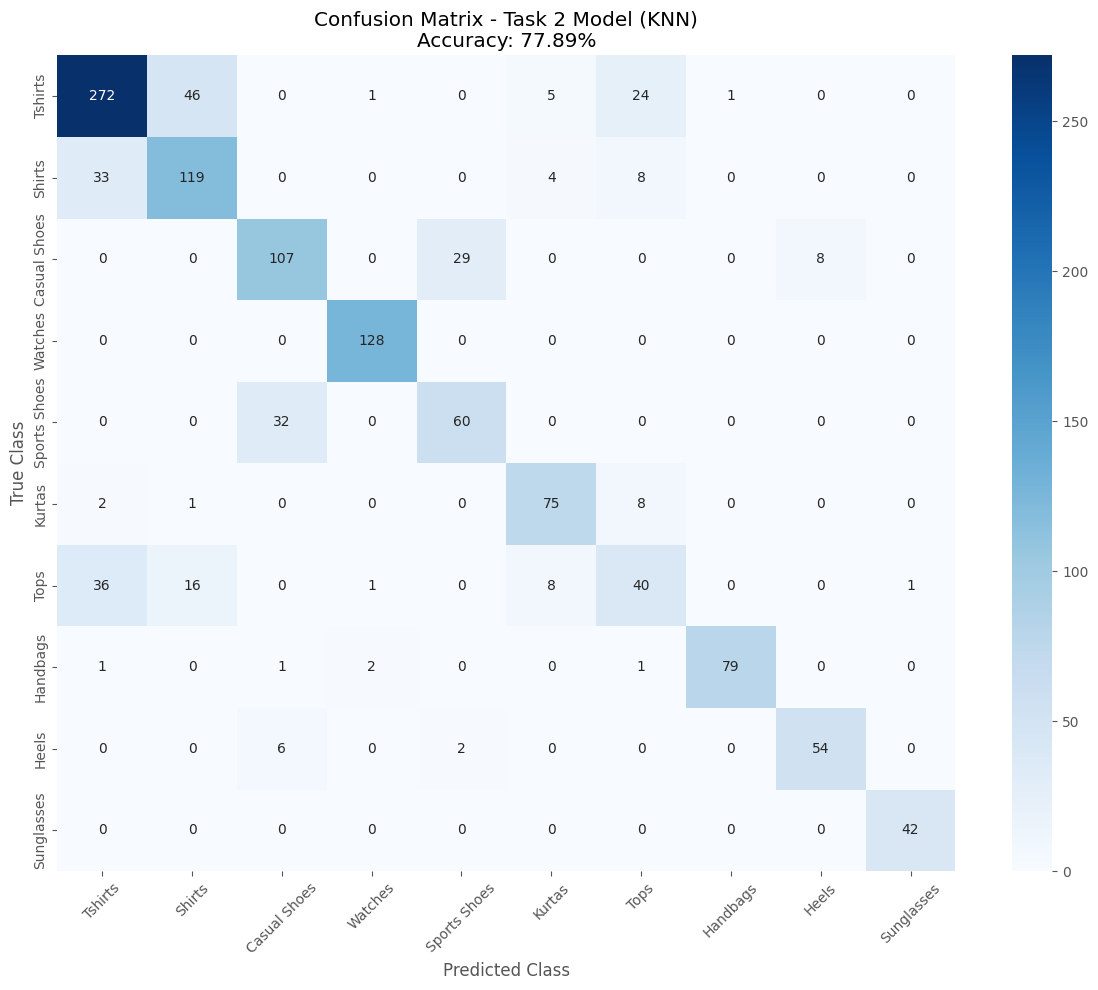

In [131]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def create_confusion_matrix_with_knn(model, support_loader, test_loader, device):
    """Create confusion matrix using embeddings"""
    
    # Extract features from support set
    model.eval()
    support_features = []
    support_labels = []
    
    with torch.no_grad():
        for inputs, labels in support_loader:
            inputs = inputs.to(device)
            features = model(inputs)  # Get embeddings
            support_features.append(features.cpu().numpy())
            support_labels.extend(labels.numpy())
    
    support_features = np.vstack(support_features)
    support_labels = np.array(support_labels)
    
    # Extract features from test set
    test_features = []
    test_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            features = model(inputs)  # Get embeddings
            test_features.append(features.cpu().numpy())
            test_labels.extend(labels.numpy())
    
    test_features = np.vstack(test_features)
    test_labels = np.array(test_labels)
    
    # Use KNN for classification
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
    knn.fit(support_features, support_labels)
    predictions = knn.predict(test_features)
    
    # Rest of confusion matrix code...
    accuracy = np.mean(predictions == test_labels) * 100
    
    # Create confusion matrix
    unique_classes = sorted(set(test_labels))
    cm = confusion_matrix(test_labels, predictions, labels=unique_classes)
    
    # Plot...
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[label_id_to_label_name.get(c, f"Class {c}") for c in unique_classes],
                yticklabels=[label_id_to_label_name.get(c, f"Class {c}") for c in unique_classes])
    
    plt.title(f'Confusion Matrix - Task 2 Model\nAccuracy: {accuracy:.2f}%')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return cm, accuracy

# Use this instead
cm, accuracy = create_confusion_matrix_with_knn(model_2, main_support_first_10_loader, main_test_first_10_loader, device)

TASK 3: COMPLETE T-SHIRT vs SHIRT TRANSITION ANALYSIS
Using main_support.csv and main_test.csv with correct labels
Support samples: 1996
Test samples: 1997

Filtered Results:
Support - Tshirts: 381
Support - Shirts: 145
Test - Tshirts: 349
Test - Shirts: 164
Total combined: 1039
Support dataset mapping: 1996 images
Test dataset mapping: 1997 images
Found 1039 valid samples total
Extracted features shape: (1039, 128)

Data Summary:
Total T-shirts: 730 samples
Total Shirts: 309 samples
Support data: 526 samples
Test data: 513 samples

Analysis Results:
Centroid distance: 1.2140
Minimum boundary distance: 0.7441
Overlap ratio: 0.6129


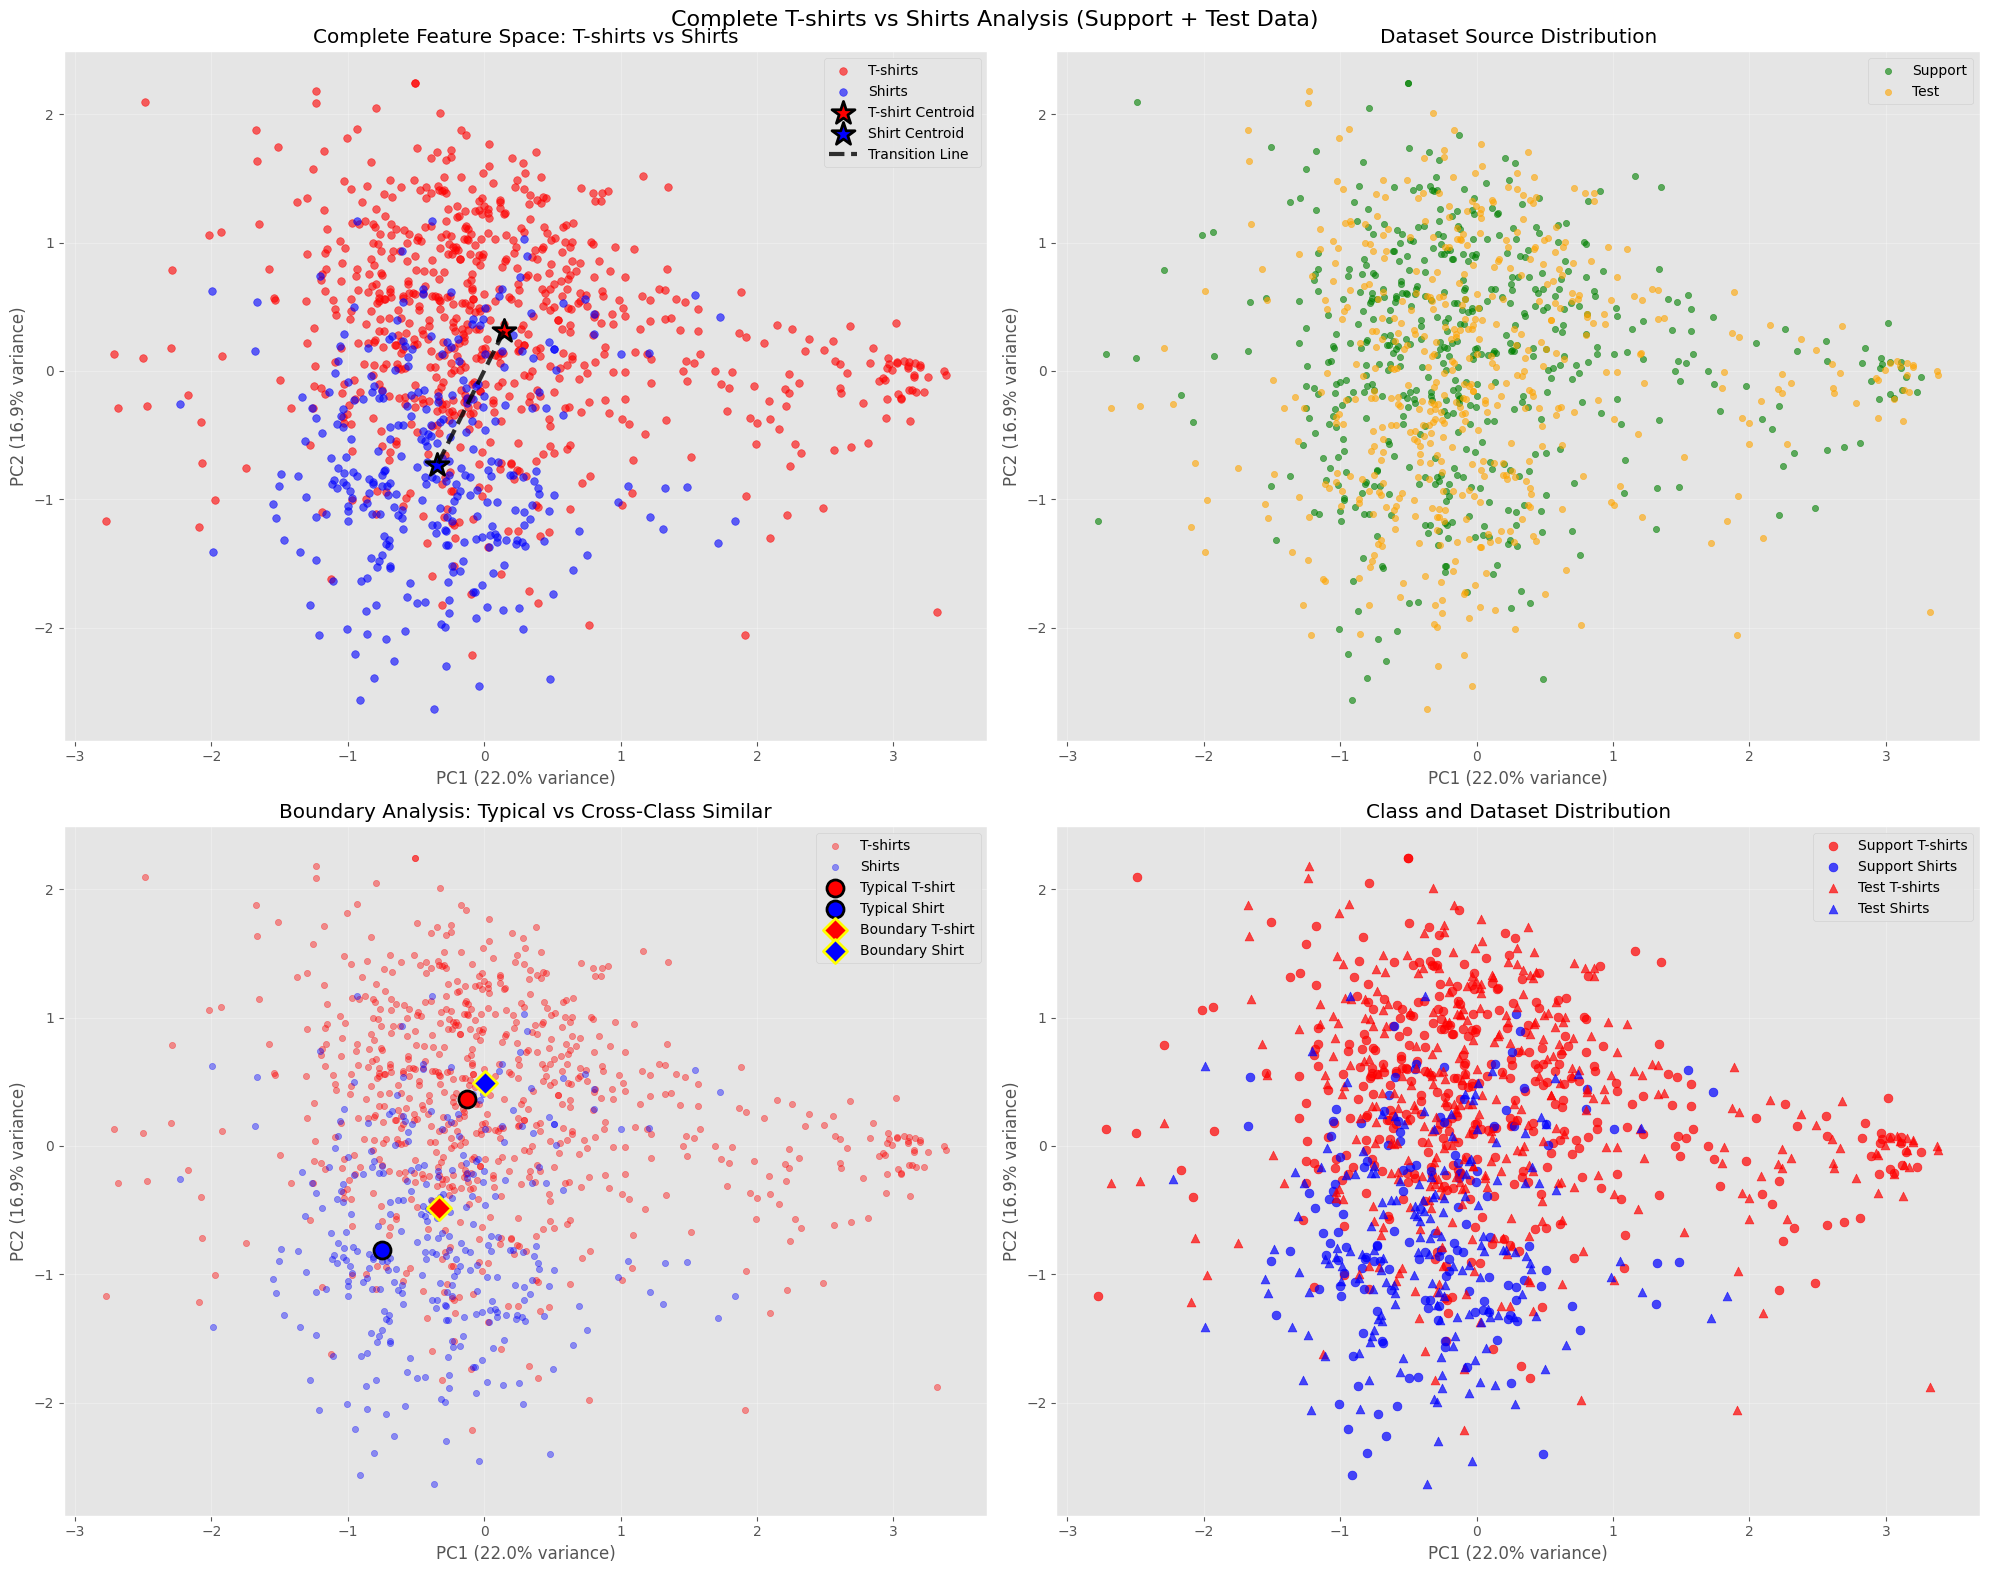

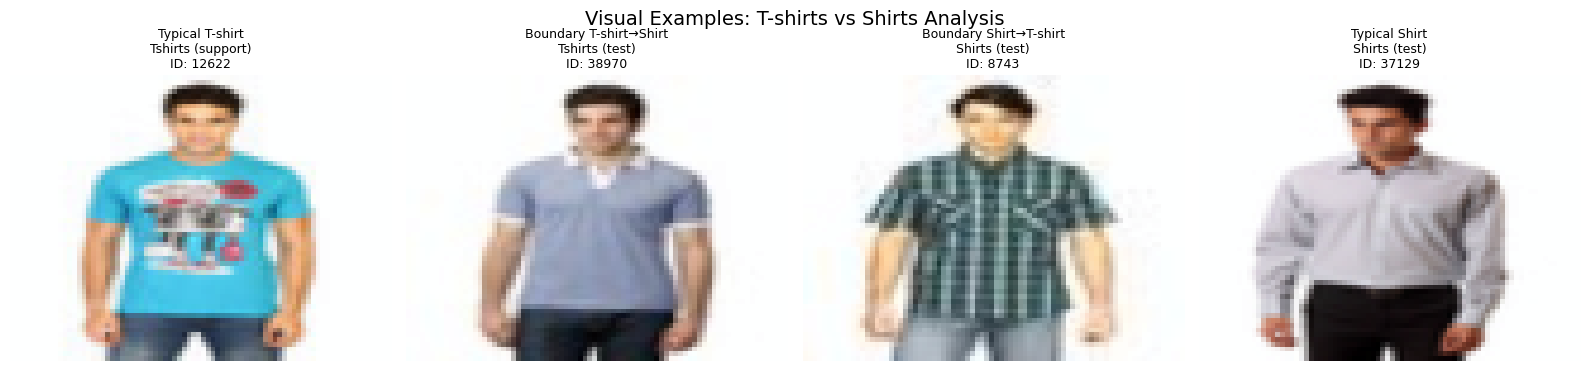


ANSWER: Do you observe characteristics that make a shirt close to a T-shirt?


In [175]:
# Task 3: Complete T-shirt vs Shirt Analysis

import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from sklearn.decomposition import PCA

print("="*80)
print("TASK 3: COMPLETE T-SHIRT vs SHIRT TRANSITION ANALYSIS")
print("Using main_support.csv and main_test.csv with correct labels")
print("="*80)

def load_complete_shirt_tshirt_data():
    """Load both main_support.csv and main_test.csv and filter for Tshirts and Shirts"""
    
    # Load both CSV files
    support_df = pd.read_csv('dataset/main_support.csv')
    test_df = pd.read_csv('dataset/main_test.csv')
    
    print(f"Support samples: {len(support_df)}")
    print(f"Test samples: {len(test_df)}")
    
    # Filter for Tshirts (articleTypeId=0) and Shirts (articleTypeId=1)
    support_filtered = support_df[support_df['articleTypeId'].isin([0, 1])].copy()
    test_filtered = test_df[test_df['articleTypeId'].isin([0, 1])].copy()
    
    # Add dataset source
    support_filtered['dataset_source'] = 'support'
    test_filtered['dataset_source'] = 'test'
    
    # Combine datasets
    combined_df = pd.concat([support_filtered, test_filtered], ignore_index=True)
    
    print(f"\nFiltered Results:")
    print(f"Support - Tshirts: {len(support_filtered[support_filtered['articleTypeId'] == 0])}")
    print(f"Support - Shirts: {len(support_filtered[support_filtered['articleTypeId'] == 1])}")
    print(f"Test - Tshirts: {len(test_filtered[test_filtered['articleTypeId'] == 0])}")
    print(f"Test - Shirts: {len(test_filtered[test_filtered['articleTypeId'] == 1])}")
    print(f"Total combined: {len(combined_df)}")
    
    return combined_df, support_filtered, test_filtered

def extract_features_complete(model, support_dataset, test_dataset, combined_df, device):
    """Extract features for both support and test datasets"""
    
    # Create mappings for both datasets
    support_id_to_idx = {}
    test_id_to_idx = {}
    
    # Map support dataset
    for idx in range(len(support_dataset)):
        try:
            image_id = support_dataset.df.iloc[idx]['imageId']
            support_id_to_idx[image_id] = idx
        except:
            continue
    
    # Map test dataset
    for idx in range(len(test_dataset)):
        try:
            image_id = test_dataset.df.iloc[idx]['imageId']
            test_id_to_idx[image_id] = idx
        except:
            continue
    
    print(f"Support dataset mapping: {len(support_id_to_idx)} images")
    print(f"Test dataset mapping: {len(test_id_to_idx)} images")
    
    # Find valid samples
    valid_samples = []
    labels = []
    dataset_indices = []
    dataset_sources = []
    
    for _, row in combined_df.iterrows():
        image_id = row['imageId']
        source = row['dataset_source']
        
        if source == 'support' and image_id in support_id_to_idx:
            dataset_idx = support_id_to_idx[image_id]
            valid_samples.append(('support', dataset_idx))
            labels.append(row['articleTypeId'])
            dataset_indices.append(dataset_idx)
            dataset_sources.append('support')
        elif source == 'test' and image_id in test_id_to_idx:
            dataset_idx = test_id_to_idx[image_id]
            valid_samples.append(('test', dataset_idx))
            labels.append(row['articleTypeId'])
            dataset_indices.append(dataset_idx)
            dataset_sources.append('test')
    
    print(f"Found {len(valid_samples)} valid samples total")
    
    if len(valid_samples) == 0:
        print("No matching samples found!")
        return None, None, None, None
    
    # Extract features
    model.eval()
    features = []
    
    with torch.no_grad():
        for i in range(0, len(valid_samples), 32):
            batch_samples = valid_samples[i:i+32]
            batch_images = []
            
            for source, idx in batch_samples:
                try:
                    if source == 'support':
                        image, _ = support_dataset[idx]
                    else:  # test
                        image, _ = test_dataset[idx]
                    batch_images.append(image)
                except:
                    continue
            
            if batch_images:
                batch_tensor = torch.stack(batch_images).to(device)
                batch_features = model(batch_tensor)
                features.append(batch_features.cpu().numpy())
    
    if features:
        features = np.vstack(features)
        print(f"Extracted features shape: {features.shape}")
        return features, np.array(labels), np.array(dataset_indices), np.array(dataset_sources)
    else:
        return None, None, None, None

def analyze_complete_transition(features, labels, dataset_indices, dataset_sources, 
                               support_dataset, test_dataset):
    """Complete analysis of T-shirt vs Shirt transition across both datasets"""
    
    # Separate by class and dataset
    tshirt_mask = labels == 0
    shirt_mask = labels == 1
    support_mask = dataset_sources == 'support'
    test_mask = dataset_sources == 'test'
    
    # Get features by class
    tshirt_features = features[tshirt_mask]
    shirt_features = features[shirt_mask]
    
    # Get features by dataset
    support_features = features[support_mask]
    test_features = features[test_mask]
    
    # Get indices
    tshirt_indices = dataset_indices[tshirt_mask]
    shirt_indices = dataset_indices[shirt_mask]
    tshirt_sources = dataset_sources[tshirt_mask]
    shirt_sources = dataset_sources[shirt_mask]
    
    print(f"\nData Summary:")
    print(f"Total T-shirts: {len(tshirt_features)} samples")
    print(f"Total Shirts: {len(shirt_features)} samples")
    print(f"Support data: {len(support_features)} samples")
    print(f"Test data: {len(test_features)} samples")
    
    # Compute centroids
    tshirt_centroid = np.mean(tshirt_features, axis=0)
    shirt_centroid = np.mean(shirt_features, axis=0)
    
    # Find boundary samples
    tshirt_to_shirt_dist = np.linalg.norm(tshirt_features - shirt_centroid, axis=1)
    shirt_to_tshirt_dist = np.linalg.norm(shirt_features - tshirt_centroid, axis=1)
    
    boundary_tshirt_idx = np.argmin(tshirt_to_shirt_dist)
    boundary_shirt_idx = np.argmin(shirt_to_tshirt_dist)
    
    # Find typical samples
    tshirt_to_own_dist = np.linalg.norm(tshirt_features - tshirt_centroid, axis=1)
    shirt_to_own_dist = np.linalg.norm(shirt_features - shirt_centroid, axis=1)
    
    typical_tshirt_idx = np.argmin(tshirt_to_own_dist)
    typical_shirt_idx = np.argmin(shirt_to_own_dist)
    
    # Calculate metrics
    centroid_distance = np.linalg.norm(shirt_centroid - tshirt_centroid)
    min_boundary_distance = min(tshirt_to_shirt_dist[boundary_tshirt_idx],
                               shirt_to_tshirt_dist[boundary_shirt_idx])
    overlap_ratio = min_boundary_distance / centroid_distance
    
    print(f"\nAnalysis Results:")
    print(f"Centroid distance: {centroid_distance:.4f}")
    print(f"Minimum boundary distance: {min_boundary_distance:.4f}")
    print(f"Overlap ratio: {overlap_ratio:.4f}")
    
    # PCA Visualization
    all_features = np.vstack([tshirt_features, shirt_features])
    pca = PCA(n_components=2)
    all_features_pca = pca.fit_transform(all_features)
    
    n_tshirt = len(tshirt_features)
    tshirt_pca = all_features_pca[:n_tshirt]
    shirt_pca = all_features_pca[n_tshirt:]
    
    # Transform centroids
    tshirt_centroid_pca = pca.transform(tshirt_centroid.reshape(1, -1))[0]
    shirt_centroid_pca = pca.transform(shirt_centroid.reshape(1, -1))[0]
    
    # Create comprehensive visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # Plot 1: Overall feature space
    ax1.scatter(tshirt_pca[:, 0], tshirt_pca[:, 1], alpha=0.6, label='T-shirts', color='red', s=30)
    ax1.scatter(shirt_pca[:, 0], shirt_pca[:, 1], alpha=0.6, label='Shirts', color='blue', s=30)
    ax1.scatter(tshirt_centroid_pca[0], tshirt_centroid_pca[1], color='red', s=300, marker='*', 
               label='T-shirt Centroid', edgecolor='black', linewidth=2)
    ax1.scatter(shirt_centroid_pca[0], shirt_centroid_pca[1], color='blue', s=300, marker='*', 
               label='Shirt Centroid', edgecolor='black', linewidth=2)
    ax1.plot([tshirt_centroid_pca[0], shirt_centroid_pca[0]], 
             [tshirt_centroid_pca[1], shirt_centroid_pca[1]], 
             'k--', linewidth=3, alpha=0.8, label='Transition Line')
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    ax1.set_title('Complete Feature Space: T-shirts vs Shirts')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Dataset source comparison
    support_pca = pca.transform(support_features)
    test_pca = pca.transform(test_features)
    ax2.scatter(support_pca[:, 0], support_pca[:, 1], alpha=0.6, label='Support', color='green', s=20)
    ax2.scatter(test_pca[:, 0], test_pca[:, 1], alpha=0.6, label='Test', color='orange', s=20)
    ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    ax2.set_title('Dataset Source Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Boundary analysis
    ax3.scatter(tshirt_pca[:, 0], tshirt_pca[:, 1], alpha=0.4, color='red', s=20, label='T-shirts')
    ax3.scatter(shirt_pca[:, 0], shirt_pca[:, 1], alpha=0.4, color='blue', s=20, label='Shirts')
    ax3.scatter(tshirt_pca[typical_tshirt_idx, 0], tshirt_pca[typical_tshirt_idx, 1], 
               color='red', s=150, marker='o', label='Typical T-shirt', edgecolor='black', linewidth=2)
    ax3.scatter(shirt_pca[typical_shirt_idx, 0], shirt_pca[typical_shirt_idx, 1], 
               color='blue', s=150, marker='o', label='Typical Shirt', edgecolor='black', linewidth=2)
    ax3.scatter(tshirt_pca[boundary_tshirt_idx, 0], tshirt_pca[boundary_tshirt_idx, 1], 
               color='red', s=150, marker='D', label='Boundary T-shirt', edgecolor='yellow', linewidth=2)
    ax3.scatter(shirt_pca[boundary_shirt_idx, 0], shirt_pca[boundary_shirt_idx, 1], 
               color='blue', s=150, marker='D', label='Boundary Shirt', edgecolor='yellow', linewidth=2)
    ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    ax3.set_title('Boundary Analysis: Typical vs Cross-Class Similar')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Combined class and dataset view
    # Separate by both class and dataset
    support_tshirt_mask = (labels == 0) & (dataset_sources == 'support')
    support_shirt_mask = (labels == 1) & (dataset_sources == 'support')
    test_tshirt_mask = (labels == 0) & (dataset_sources == 'test')
    test_shirt_mask = (labels == 1) & (dataset_sources == 'test')
    
    if np.any(support_tshirt_mask):
        support_tshirt_pca = pca.transform(features[support_tshirt_mask])
        ax4.scatter(support_tshirt_pca[:, 0], support_tshirt_pca[:, 1], 
                   alpha=0.7, color='red', marker='o', s=40, label='Support T-shirts')
    
    if np.any(support_shirt_mask):
        support_shirt_pca = pca.transform(features[support_shirt_mask])
        ax4.scatter(support_shirt_pca[:, 0], support_shirt_pca[:, 1], 
                   alpha=0.7, color='blue', marker='o', s=40, label='Support Shirts')
    
    if np.any(test_tshirt_mask):
        test_tshirt_pca = pca.transform(features[test_tshirt_mask])
        ax4.scatter(test_tshirt_pca[:, 0], test_tshirt_pca[:, 1], 
                   alpha=0.7, color='red', marker='^', s=40, label='Test T-shirts')
    
    if np.any(test_shirt_mask):
        test_shirt_pca = pca.transform(features[test_shirt_mask])
        ax4.scatter(test_shirt_pca[:, 0], test_shirt_pca[:, 1], 
                   alpha=0.7, color='blue', marker='^', s=40, label='Test Shirts')
    
    ax4.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax4.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    ax4.set_title('Class and Dataset Distribution')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('Complete T-shirts vs Shirts Analysis (Support + Test Data)', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Display example images
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    examples = [
        ('Typical T-shirt', tshirt_indices[typical_tshirt_idx], tshirt_sources[typical_tshirt_idx]),
        ('Boundary T-shirt→Shirt', tshirt_indices[boundary_tshirt_idx], tshirt_sources[boundary_tshirt_idx]),
        ('Boundary Shirt→T-shirt', shirt_indices[boundary_shirt_idx], shirt_sources[boundary_shirt_idx]),
        ('Typical Shirt', shirt_indices[typical_shirt_idx], shirt_sources[typical_shirt_idx])
    ]
    
    for i, (title, dataset_idx, source) in enumerate(examples):
        try:
            if source == 'support':
                image, _ = support_dataset[dataset_idx]
                image_id = support_dataset.df.iloc[dataset_idx]['imageId']
                article_name = support_dataset.df.iloc[dataset_idx]['articleTypeName']
            else:  # test
                image, _ = test_dataset[dataset_idx]
                image_id = test_dataset.df.iloc[dataset_idx]['imageId']
                article_name = test_dataset.df.iloc[dataset_idx]['articleTypeName']
            
            if torch.is_tensor(image):
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image_np = image.permute(1, 2, 0).numpy()
                image_np = image_np * std + mean
                image_np = np.clip(image_np, 0, 1)
            else:
                image_np = np.array(image)
            
            axes[i].imshow(image_np)
            axes[i].set_title(f'{title}\n{article_name} ({source})\nID: {image_id}', fontsize=9)
            axes[i].axis('off')
            
        except Exception as e:
            print(f"Error displaying {title}: {e}")
            axes[i].text(0.5, 0.5, f'Error\n{title}', ha='center', va='center')
            axes[i].axis('off')
    
    plt.suptitle('Visual Examples: T-shirts vs Shirts Analysis', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return {
        'overlap_ratio': overlap_ratio,
        'centroid_distance': centroid_distance,
        'n_tshirts': len(tshirt_features),
        'n_shirts': len(shirt_features),
        'n_support': len(support_features),
        'n_test': len(test_features)
    }

combined_df, support_df, test_df = load_complete_shirt_tshirt_data()
features, labels, indices, sources = extract_features_complete(model, main_support_dataset, main_test_dataset, combined_df, device)
results = analyze_complete_transition(features, labels, indices, sources, main_support_dataset, main_test_dataset)

In [172]:
# Step 4: Hierarchical Classification with Balanced Accuracy

import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from collections import defaultdict

def create_article_to_category_mapping(dataset):
    """Create mapping from articleTypeId to categoryId using the dataset"""
    df = dataset.df
    mapping_df = df[['articleTypeId', 'categoryId', 'articleTypeName', 'categoryName']].drop_duplicates()
    mapping_df = mapping_df.sort_values('articleTypeId')
    
    # Create the mapping dictionary
    article_to_category = {}
    category_names = {}
    article_names = {}
    
    for _, row in mapping_df.iterrows():
        article_id = int(row['articleTypeId'])
        category_id = int(row['categoryId'])
        article_to_category[article_id] = category_id
        category_names[category_id] = row['categoryName']
        article_names[article_id] = row['articleTypeName']
    
    print("\nArticle Type to Category Mapping:")
    print("=" * 60)
    for article_id in sorted(article_to_category.keys()):
        category_id = article_to_category[article_id]
        print(f"Article {article_id:2d} ({article_names[article_id]:15s}) -> Category {category_id:2d} ({category_names[category_id]})")
    
    print(f"\nTotal Article Types: {len(article_to_category)}")
    print(f"Total Categories: {len(set(article_to_category.values()))}")
    
    return article_to_category, category_names, article_names

def extract_features(model, dataloader, device):
    """Extract features using the trained Task 2 model"""
    model.eval()
    features = []
    article_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)  # Get embeddings
            features.append(outputs.cpu().numpy())
            article_labels.extend(labels.numpy())
    
    features = np.vstack(features)
    article_labels = np.array(article_labels)
    
    return features, article_labels

def convert_to_category_labels(article_labels, article_to_category):
    """Convert article type labels to category labels"""
    return np.array([article_to_category[art_id] for art_id in article_labels])

def evaluate_hierarchical_classification_enhanced(train_features, train_labels, test_features, test_labels, 
                                                category_names, k=1, level_name=""):
    """Enhanced evaluation with both regular and balanced accuracy"""
    
    # Train k-NN classifier
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    knn.fit(train_features, train_labels)
    
    # Predict on test set
    predictions = knn.predict(test_features)
    
    # Calculate both accuracies
    accuracy = accuracy_score(test_labels, predictions)
    balanced_acc = balanced_accuracy_score(test_labels, predictions)
    
    # Print enhanced results
    print(f"\n{level_name} Classification Results:")
    print("=" * 60)
    print(f"Regular Accuracy:     {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Balanced Accuracy:    {balanced_acc:.4f} ({balanced_acc*100:.2f}%)")
    print(f"Number of samples:    {len(test_labels)}")
    print(f"Number of classes:    {len(np.unique(test_labels))}")
    
    # Calculate per-class metrics for insight
    unique_classes = np.unique(test_labels)
    per_class_acc = []
    class_counts = []
    
    for cls in unique_classes:
        mask = test_labels == cls
        cls_count = np.sum(mask)
        if cls_count > 0:
            cls_acc = accuracy_score(test_labels[mask], predictions[mask])
            per_class_acc.append(cls_acc)
            class_counts.append(cls_count)
    
    print(f"Mean per-class acc:   {np.mean(per_class_acc):.4f} ({np.mean(per_class_acc)*100:.2f}%)")
    print(f"Std per-class acc:    {np.std(per_class_acc):.4f}")
    print(f"Min/Max class size:   {min(class_counts)} / {max(class_counts)} samples")
    
    # Generate detailed report for smaller number of classes
    if len(unique_classes) <= 25:  # Only show detailed report for manageable number of classes
        try:
            target_names = [category_names.get(i, f"Class_{i}") for i in sorted(unique_classes)]
            report = classification_report(test_labels, predictions, 
                                         target_names=target_names,
                                         digits=3, zero_division=0)
            print(f"\nDetailed Classification Report:")
            print(report)
        except:
            print("\nDetailed report generation skipped due to class naming issues.")
    
    return predictions, accuracy, balanced_acc

def compare_hierarchical_performance_enhanced(model, train_loader, test_loader, article_to_category, 
                                            category_names, device):
    """Enhanced comparison with balanced accuracy metrics"""
    
    print("="*80)
    print("ENHANCED HIERARCHICAL CLASSIFICATION EVALUATION")
    print("Comparing Article-level vs Category-level with Balanced Accuracy")
    print("="*80)
    
    # Extract features
    print("Extracting features from training data...")
    train_features, train_article_labels = extract_features(model, train_loader, device)
    print("Extracting features from test data...")
    test_features, test_article_labels = extract_features(model, test_loader, device)
    
    # Convert to category labels
    train_category_labels = convert_to_category_labels(train_article_labels, article_to_category)
    test_category_labels = convert_to_category_labels(test_article_labels, article_to_category)
    
    # Evaluate article-level classification
    print("\n" + "="*70)
    print("ARTICLE-LEVEL CLASSIFICATION (Fine-grained)")
    print("="*70)
    article_predictions, article_accuracy, article_balanced_acc = evaluate_hierarchical_classification_enhanced(
        train_features, train_article_labels, test_features, test_article_labels, 
        {i: f"Article_{i}" for i in range(max(test_article_labels)+1)}, 
        level_name="Article-level")
    
    # Evaluate category-level classification
    print("\n" + "="*70)
    print("CATEGORY-LEVEL CLASSIFICATION (Coarse-grained)")
    print("="*70)
    category_predictions, category_accuracy, category_balanced_acc = evaluate_hierarchical_classification_enhanced(
        train_features, train_category_labels, test_features, test_category_labels, 
        category_names, level_name="Category-level")
    
    # Enhanced performance comparison
    print("\n" + "="*80)
    print("COMPREHENSIVE PERFORMANCE COMPARISON")
    print("="*80)
    
    print(f"Article-level ({len(np.unique(test_article_labels))} classes):")
    print(f"  Regular Accuracy:     {article_accuracy:.4f} ({article_accuracy*100:.2f}%)")
    print(f"  Balanced Accuracy:    {article_balanced_acc:.4f} ({article_balanced_acc*100:.2f}%)")
    
    print(f"\nCategory-level ({len(np.unique(test_category_labels))} classes):")
    print(f"  Regular Accuracy:     {category_accuracy:.4f} ({category_accuracy*100:.2f}%)")
    print(f"  Balanced Accuracy:    {category_balanced_acc:.4f} ({category_balanced_acc*100:.2f}%)")
    
    # Calculate improvements
    improvement_regular = category_accuracy - article_accuracy
    improvement_balanced = category_balanced_acc - article_balanced_acc
    
    print(f"\nHierarchical Performance Gains:")
    print(f"  Regular Accuracy:     {improvement_regular:+.4f} ({improvement_regular*100:+.2f}%)")
    print(f"  Balanced Accuracy:    {improvement_balanced:+.4f} ({improvement_balanced*100:+.2f}%)")
    
    # Enhanced visualization
    create_enhanced_visualization(article_accuracy, article_balanced_acc, 
                                category_accuracy, category_balanced_acc,
                                len(np.unique(test_article_labels)), 
                                len(np.unique(test_category_labels)))
    
    # Interpretation
    print("\n" + "="*80)
    print("INTERPRETATION & INSIGHTS")
    print("="*80)
    
    if improvement_regular > 0 and improvement_balanced > 0:
        print("✅ EXCELLENT: Both metrics improve at category level!")
        print("   Your model learned meaningful hierarchical patterns.")
    elif improvement_regular > 0 or improvement_balanced > 0:
        print("✅ GOOD: At least one metric improves at category level.")
        if improvement_balanced > improvement_regular:
            print("   Balanced accuracy improvement suggests better class balance handling.")
        else:
            print("   Regular accuracy improvement suggests overall better performance.")
    else:
        print("⚠️  INTERESTING: Article-level performs better.")
        print("   Model learned very specific article-level discriminative features.")
    
    return {
        'article_accuracy': article_accuracy,
        'article_balanced_accuracy': article_balanced_acc,
        'category_accuracy': category_accuracy,
        'category_balanced_accuracy': category_balanced_acc,
        'improvements': {
            'regular': improvement_regular,
            'balanced': improvement_balanced
        }
    }

def create_enhanced_visualization(article_acc, article_bal_acc, category_acc, category_bal_acc,
                                num_article_classes, num_category_classes):
    """Create enhanced visualization with both accuracy metrics"""
    
    metrics = ['Regular Accuracy', 'Balanced Accuracy']
    article_scores = [article_acc, article_bal_acc]
    category_scores = [category_acc, category_bal_acc]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Main comparison plot
    bars1 = ax1.bar(x - width/2, article_scores, width, 
                   label=f'Article-level ({num_article_classes} classes)', 
                   alpha=0.8, color='skyblue')
    bars2 = ax1.bar(x + width/2, category_scores, width, 
                   label=f'Category-level ({num_category_classes} classes)', 
                   alpha=0.8, color='lightcoral')
    
    ax1.set_xlabel('Accuracy Metric', fontsize=12)
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title('Enhanced Hierarchical Classification Performance\n(Task 2 Embedding Model + k-NN)', fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.0)
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    for bar in bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Improvement plot
    improvements = [category_acc - article_acc, category_bal_acc - article_bal_acc]
    colors = ['green' if imp > 0 else 'red' for imp in improvements]
    
    bars3 = ax2.bar(metrics, improvements, alpha=0.7, color=colors)
    ax2.set_ylabel('Improvement (Category - Article)', fontsize=12)
    ax2.set_title('Performance Improvement\n(Category vs Article Level)', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # Add value labels for improvements
    for bar, imp in zip(bars3, improvements):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + (0.005 if height > 0 else -0.015),
               f'{imp:+.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Usage example for notebook:
"""
# Load the trained model from Task 2
model = FashionNetT2(embedding_dim=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('task2_model.pth'))
model.to(device)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(main_test_dataset, batch_size=batch_size, shuffle=False)

# Create category mapping
article_to_category, category_names, article_names = create_article_to_category_mapping(train_dataset)

# Run enhanced hierarchical evaluation with balanced accuracy
results = compare_hierarchical_performance_enhanced(model, train_loader, test_loader, 
                                                  article_to_category, category_names, device)
""" 

'\n# Load the trained model from Task 2\nmodel = FashionNetT2(embedding_dim=128)\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel.load_state_dict(torch.load(\'task2_model.pth\'))\nmodel.to(device)\n\n# Create data loaders\nbatch_size = 32\ntrain_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)\ntest_loader = DataLoader(main_test_dataset, batch_size=batch_size, shuffle=False)\n\n# Create category mapping\narticle_to_category, category_names, article_names = create_article_to_category_mapping(train_dataset)\n\n# Run enhanced hierarchical evaluation with balanced accuracy\nresults = compare_hierarchical_performance_enhanced(model, train_loader, test_loader, \n                                                  article_to_category, category_names, device)\n'

C:\Users\Andy\AppData\Local\Temp\ipykernel_21800\2106445861.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('task2_model.pth'))



Article Type to Category Mapping:
Article  0 (Tshirts        ) -> Category  0 (Topwear)
Article  1 (Shirts         ) -> Category  0 (Topwear)
Article  2 (Casual Shoes   ) -> Category  1 (Shoes)
Article  3 (Watches        ) -> Category  3 (Watches)
Article  4 (Sports Shoes   ) -> Category  1 (Shoes)
Article  5 (Kurtas         ) -> Category  0 (Topwear)
Article  6 (Tops           ) -> Category  0 (Topwear)
Article  7 (Handbags       ) -> Category  2 (Bags)
Article  8 (Heels          ) -> Category  1 (Shoes)
Article  9 (Sunglasses     ) -> Category  7 (Eyewear)
Article 10 (Wallets        ) -> Category  2 (Bags)
Article 11 (Flip Flops     ) -> Category 11 (Flip Flops)
Article 12 (Sandals        ) -> Category  1 (Shoes)
Article 13 (Briefs         ) -> Category  5 (Innerwear)
Article 14 (Belts          ) -> Category 12 (Belts)
Article 15 (Backpacks      ) -> Category  2 (Bags)
Article 16 (Socks          ) -> Category 13 (Socks)
Article 17 (Formal Shoes   ) -> Category  1 (Shoes)
Article 18 

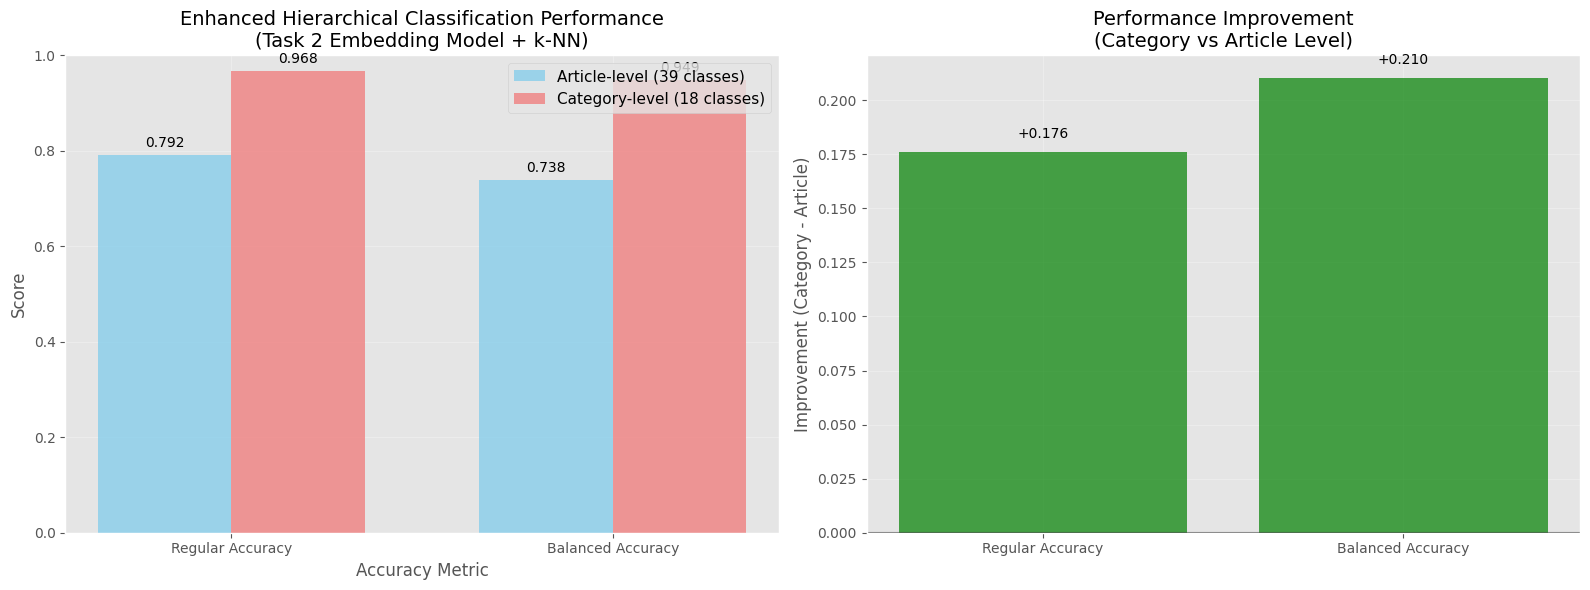


INTERPRETATION & INSIGHTS
✅ EXCELLENT: Both metrics improve at category level!
   Your model learned meaningful hierarchical patterns.


In [173]:


# Load the trained model from Task 2
model = FashionNetT2(embedding_dim=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('task2_model.pth'))
model.to(device)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(main_test_dataset, batch_size=batch_size, shuffle=False)

# Create category mapping
article_to_category, category_names, article_names = create_article_to_category_mapping(train_dataset)

# Run enhanced hierarchical evaluation with balanced accuracy
results = compare_hierarchical_performance_enhanced(model, train_loader, test_loader, 
                                            article_to_category, category_names, device)
